# Introduction

This example demonstrates how to convert a network from [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for use with Lasagne. We will be using the Caffe version of CIFAR-10 Model.

We will create a set of Lasagne layers corresponding to the Caffe model specification (prototxt), then copy the parameters from the caffemodel file into our model.

# Converting from Caffe to Lasagne
### Download the required files

First we download `cifar10_nin.caffemodel` and `model.prototxt`. The supplied `train_val.prototxt` was modified to replace the data layers with an input specification, and remove the unneeded loss/accuracy layers.

### Import Caffe

To load the saved parameters, we'll need to have Caffe's Python bindings installed.

In [1]:
import sys
caffe_root = '/home/xilinx/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe

### Load the pretrained Caffe network

In [2]:
net_caffe = caffe.Net('CIFAR_10.prototxt', 'cifar10_quick_iter_5000.caffemodel.h5', caffe.TEST)

### Import Lasagne

In [3]:
import lasagne
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer, NonlinearityLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify, linear
import conv_fpga
from conv_fpga import FPGA_CIFAR10
from conv_fpga import FPGAQuickTest
#from conv_fpga import Conv2DLayer as ConvLayer
from conv_fpga import FPGAWeightLoader as FPGALoadW
from lasagne.utils import floatX

### Create a Lasagne network
Layer names match those in `model.prototxt`

In [4]:
net = {}
net['input'] = InputLayer((None, 3, 32, 32))
net['conv1'] = ConvLayer(net['input'], num_filters=32, filter_size=5, pad=2, nonlinearity=None)
net['pool1'] = PoolLayer(net['conv1'], pool_size=2, stride=2, mode='max', ignore_border=False)
net['relu1'] = NonlinearityLayer(net['pool1'], rectify)
net['conv2'] = ConvLayer(net['relu1'], num_filters=32, filter_size=5, pad=2, nonlinearity=rectify)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, mode='average_exc_pad', ignore_border=False)
net['conv3'] = ConvLayer(net['pool2'], num_filters=64, filter_size=5, pad=2, nonlinearity=rectify)
net['pool3'] = PoolLayer(net['conv3'], pool_size=2, stride=2, mode='average_exc_pad', ignore_border=False)
net['ip1'] = DenseLayer(net['pool3'], num_units=64, nonlinearity = None)
net['ip2'] = DenseLayer(net['ip1'], num_units=10, nonlinearity = None)
net['prob'] = NonlinearityLayer(net['ip2'], softmax)

### Copy the parameters from Caffe to Lasagne

In [5]:
import numpy as np

layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:   
        if name=='ip1'or name=='ip2':
            layer.W.set_value(np.transpose(layers_caffe[name].blobs[0].data))
            layer.b.set_value(layers_caffe[name].blobs[1].data)
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data[:,:,::-1,::-1])
            layer.b.set_value(layers_caffe[name].blobs[1].data)
            
    except AttributeError:
        continue

### Copy the parameters from CPU to FPGA OnChip Memory

In [6]:
#FPGALoadW(weight, status, IFDim, OFDim, PadDim)
weight = net['conv1'].W.get_value()
FPGALoadW(weight, 1, 32, 32, 2)
weight = net['conv2'].W.get_value()
FPGALoadW(weight, 2, 16, 16, 2)
weight = net['conv3'].W.get_value()
FPGALoadW(weight, 3, 8, 8, 2)
weight = net['ip1'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(64, 64, 4, 4)
FPGALoadW(weight, 4, 4, 1, 0, flip_filters=False)
weight = net['ip2'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(10, 64, 1, 1)
FPGALoadW(weight, 5, 1, 1, 0, flip_filters=False)

weight shape (32, 3, 5, 5)
kermax 0.191131100059
kermin -0.26925727725
Elapsed Test Time:  0.002257811999999859
weight shape (32, 32, 5, 5)
kermax 0.112733885646
kermin -0.121608451009
Elapsed Test Time:  0.0007232489999999814
weight shape (64, 32, 5, 5)
kermax 0.0932634323835
kermin -0.0825128629804
Elapsed Test Time:  0.0013065350000012188
weight shape (64, 64, 4, 4)
kermax 0.366065233946
kermin -0.347633630037
Elapsed Test Time:  0.0016316950000003771
weight shape (10, 64, 1, 1)
kermax 0.284343063831
kermin -0.279969036579
Elapsed Test Time:  0.00022236299999889297


# Trying it out
Let's see if that worked. 

### Import numpy and set up plotting
### Import time

In [7]:
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import time

%matplotlib inline

### Download some test data
Load CIFAR_10 test data.

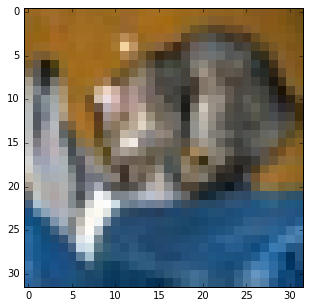

In [8]:
data = np.load('cifar10.npz')
mean_image = np.load('mean_image.npy')
data_zeromean = data['raw'] - mean_image

def make_image(X):
    im = np.swapaxes(X.T, 0, 1)
    im = im - im.min()
    im = im * 1.0 / im.max()
    return im
plt.figure(figsize=(5, 5))
plt.imshow(make_image(data['raw'][0]), interpolation='nearest')

### FPGA Deployment (CIFAR10 Layer)

In [9]:
FPGA_net = {}
FPGA_net['input'] = InputLayer((None, 3, 32, 32))
FPGA_net['cifar10'] = FPGA_CIFAR10(FPGA_net['input'])
FPGA_net['prob'] = NonlinearityLayer(FPGA_net['cifar10'], softmax)

In [10]:
batch_size = 500

%time prob = lasagne.layers.get_output(FPGA_net['cifar10'], floatX(data_zeromean[0:batch_size]*64), deterministic=True)#.eval()
FPGA_predicted = np.argmax(prob, 1)

Elapsed Test Time:  3.339811682000004
CPU times: user 10.1 s, sys: 4.3 s, total: 14.4 s
Wall time: 11.1 s


In [11]:
FPGA_accuracy = np.mean(FPGA_predicted == data['labels'][0:batch_size])
#print(FPGA_predicted)
#print(data['labels'][0:batch_size])
print(FPGA_accuracy)

0.732


### FPGA Deployment (QuickTest Function)

In [12]:
batch_size = 500

OFMDim = 1
OFMCH = 10
%time FPGA_output = FPGAQuickTest(data_zeromean*64, batch_size, OFMDim, OFMCH)
FPGA_predicted = np.argmax(FPGA_output.reshape(batch_size, -1), 1)

Elapsed Test Time:  3.3399151200000006
CPU times: user 3.64 s, sys: 180 ms, total: 3.82 s
Wall time: 3.81 s


In [13]:
FPGA_accuracy = np.mean(FPGA_predicted == data['labels'][0:batch_size])
#print(FPGA_predicted)
#print(FPGA_accuracy)
print(data_zeromean.shape)

(1000, 3, 32, 32)


### Graph some images and predictions

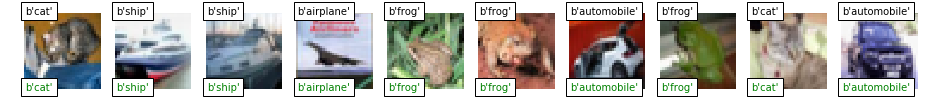

In [14]:
def make_image(X):
    im = np.swapaxes(X.T, 0, 1)
    im = im - im.min()
    im = im * 1.0 / im.max()
    return im

plt.figure(figsize=(16, 5))
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow(make_image(data['raw'][i]), interpolation='nearest')
    true = data['CLASSES'][data['labels'][i]]
    pred = data['CLASSES'][FPGA_predicted[i]]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')

### ARM CPU Deployment

In [15]:
batch_size = 500

start_time = time.process_time()
prob = np.array(lasagne.layers.get_output(net['prob'], floatX(data_zeromean[0:batch_size]), deterministic=True).eval())
predicted = np.argmax(prob, 1)
end_time = time.process_time()
print("Elapsed Test Time: ", end_time-start_time)

Elapsed Test Time:  160.62767469800002


### Check our accuracy
We expect around 75%

In [16]:
accuracy = np.mean(predicted == data['labels'][0:batch_size])
# print(predicted)
# print(data['labels'][0:500])
print(accuracy)

0.746
